<a href="https://colab.research.google.com/github/spdrnl/ecg/blob/master/ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

# Move data from Drive to /tmp

In [2]:
from google.colab import drive
drive.mount("/tmp/drive")
! unzip "/tmp/drive/My Drive/data/29414_37484_bundle_archive.zip" -d /tmp/ecg
! ls /tmp/ecg

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /tmp/drive
Archive:  /tmp/drive/My Drive/data/29414_37484_bundle_archive.zip
  inflating: /tmp/ecg/mitbih_test.csv  
  inflating: /tmp/ecg/mitbih_train.csv  
  inflating: /tmp/ecg/ptbdb_abnormal.csv  
  inflating: /tmp/ecg/ptbdb_normal.csv  
mitbih_test.csv  mitbih_train.csv  ptbdb_abnormal.csv  ptbdb_normal.csv


# Import and analyse data
## MIT-BIH Arrhythmia dataset

In [3]:
mitbih_test = pd.read_csv("/tmp/ecg/mitbih_test.csv", header=None)
mitbih_train = pd.read_csv("/tmp/ecg/mitbih_train.csv", header=None)

In [4]:
mitbih_labels = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
mitbih_reverse_labels = {v:k for k,v in mitbih_labels.items()}
mitbih_train['labels'] = mitbih_train.iloc[:,-1].replace(mitbih_reverse_labels)
mitbih_test['labels'] = mitbih_test.iloc[:,-1].replace(mitbih_reverse_labels)

In [5]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [6]:
print("The minimum and maximum values are {}, {}".format(np.min(mitbih_train.iloc[:,:-2].values), np.max(mitbih_train.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


Text(0.5, 1.0, 'Distribution of labels in MIT-BIH Arrhythmia dataset')

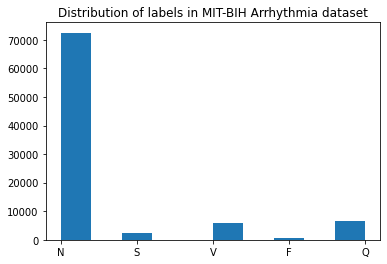

In [72]:
plt.hist(mitbih_train['labels'])
plt.title("Distribution of labels in MIT-BIH Arrhythmia dataset")

Text(0.5, 1.0, 'MIT-BIH Arrhythmia Dataset example signal')

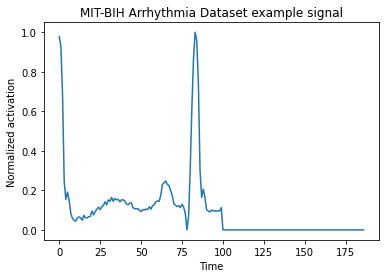

In [8]:
plt.plot(mitbih_train.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("MIT-BIH Arrhythmia Dataset example signal")

## PTB Diagnostic ECG Database

In [9]:
ptbdb_abnormal = pd.read_csv("/tmp/ecg/ptbdb_abnormal.csv", header=None)
ptbdb_normal = pd.read_csv("/tmp/ecg/ptbdb_normal.csv", header=None)

In [10]:
ptbdb_labels = {'Normal': 0, 'Abnormal': 1}
ptbdb_reverse_labels = {v:k for k,v in ptbdb_labels.items()}
ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0, ignore_index=True)
ptbdb['labels'] = ptbdb.iloc[:,-1].replace(ptbdb_reverse_labels)

In [14]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [15]:
print("The minimum and maximum values are {}, {}".format(np.min(ptbdb.iloc[:,:-2].values), np.max(ptbdb.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


Text(0.5, 1.0, 'Distribution of the PTB Diagnostic ECG Database labels')

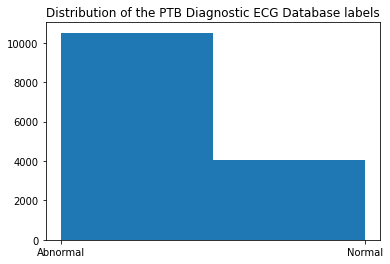

In [16]:
plt.hist(ptbdb['labels'], bins=2)
plt.title("Distribution of the PTB Diagnostic ECG Database labels")

Text(0.5, 1.0, 'PTB Diagnostic ECG Database example signal')

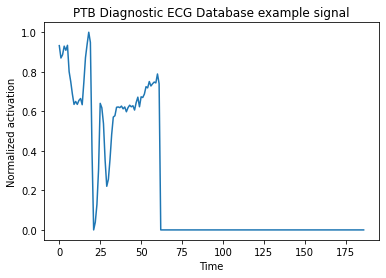

In [17]:
plt.plot(ptbdb.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("PTB Diagnostic ECG Database example signal")

## Creating datasets

In [18]:
print(ptbdb.shape)
print(mitbih_train.shape)
print(mitbih_test.shape)

(14552, 189)
(87554, 189)
(21892, 189)


In [66]:
X_mitbih_train = mitbih_train.iloc[:,:-2].values
y_mitbih_train = mitbih_train.iloc[:,-2].values

X_mitbih_test = mitbih_test.iloc[:,:-2].values
y_mitbih_test = mitbih_test.iloc[:,-2].values

X_ptbdb_train, X_ptbdb_test, y_ptbdb_train, y_ptbdb_test = train_test_split(ptbdb.iloc[:,:-2].values, ptbdb.iloc[:,-2].values, test_size=0.2, random_state=42)
X_ptbdb_train, X_ptbdb_val, y_ptbdb_train, y_ptbdb_val = train_test_split(X_ptbdb_train, y_ptbdb_train, test_size=0.2, random_state=42)


# Baseline MLP

In [55]:
regularizer = keras.regularizers.l2(0.001)
model = keras.Sequential([
  keras.layers.Dense(15, activation='relu', input_shape=[187], kernel_regularizer=regularizer),
  keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizer),
  keras.layers.Dense(5, activation='relu', kernel_regularizer=regularizer),
  keras.layers.Dense(1, activation='sigmoid')                  
])

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_ptbdb_train, y_ptbdb_train, validation_data=(X_ptbdb_val, y_ptbdb_val), batch_size=128, epochs=200)

Epoch 1/200
73/73 [==============================] - 0s 5ms/step - loss: 0.7226 - accuracy: 0.6349 - val_loss: 0.6828 - val_accuracy: 0.7222
Epoch 2/200
73/73 [==============================] - 0s 3ms/step - loss: 0.6101 - accuracy: 0.7168 - val_loss: 0.5491 - val_accuracy: 0.7218
Epoch 3/200
73/73 [==============================] - 0s 4ms/step - loss: 0.5193 - accuracy: 0.7525 - val_loss: 0.4916 - val_accuracy: 0.7922
Epoch 4/200
73/73 [==============================] - 0s 4ms/step - loss: 0.4711 - accuracy: 0.7840 - val_loss: 0.4511 - val_accuracy: 0.8059
Epoch 5/200
73/73 [==============================] - 0s 4ms/step - loss: 0.4455 - accuracy: 0.7940 - val_loss: 0.4313 - val_accuracy: 0.8068
Epoch 6/200
73/73 [==============================] - 0s 4ms/step - loss: 0.4313 - accuracy: 0.8044 - val_loss: 0.4179 - val_accuracy: 0.8154
Epoch 7/200
73/73 [==============================] - 0s 4ms/step - loss: 0.4178 - accuracy: 0.8143 - val_loss: 0.4033 - val_accuracy: 0.8304
Epoch 8/200
7

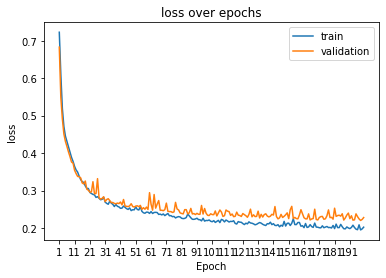

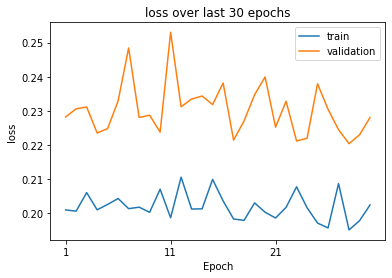

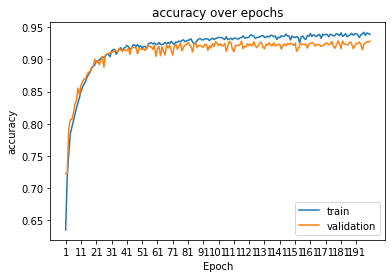

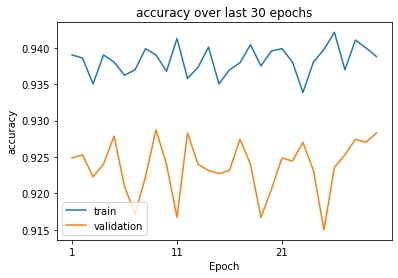

In [56]:
def pretty_plot(history, field):
  def plot(data, val_data, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(1, len(data)+1, 10))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  plot(data, val_data, "{} over epochs".format(field))
  plot(data[-tail:], val_data[-tail:], "{} over last {} epochs".format(field, tail))


pretty_plot(history, 'loss')
pretty_plot(history, 'accuracy')


# Replication ResNet

In [67]:
def residual_block(X, kernels, stride):
  out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
  out = keras.layers.ReLU()(out)
  out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
  out = keras.layers.add([X, out])
  out = keras.layers.ReLU()(out)
  out = keras.layers.MaxPool1D(5, 2)(out)
  return out

kernels = 32
stride = 5

inputs = keras.layers.Input([187,1])
X = keras.layers.Conv1D(kernels, stride)(inputs)
X = residual_block(X, kernels, stride)
X = residual_block(X, kernels, stride)
X = residual_block(X, kernels, stride)
X = residual_block(X, kernels, stride)
X = residual_block(X, kernels, stride)
X = keras.layers.Flatten()(X)
X = keras.layers.Dense(32, activation='relu')(X)
X = keras.layers.Dense(32, activation='relu')(X)
output = keras.layers.Dense(1, activation='sigmoid')(X)

model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 183, 32)      192         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_36 (Conv1D)              (None, 183, 32)      5152        conv1d_35[0][0]                  
__________________________________________________________________________________________________
re_lu_30 (ReLU)                 (None, 183, 32)      0           conv1d_36[0][0]                  
____________________________________________________________________________________________

In [70]:
X_ptbdbl_train = np.expand_dims(X_ptbdb_train, -1)
y_ptbdbl_train = np.expand_dims(y_ptbdb_train, -1)
X_ptbdbl_val = np.expand_dims(X_ptbdb_val, -1)
y_ptbdbl_val = np.expand_dims(y_ptbdb_val, -1)

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), batch_size=128, epochs=50)

Epoch 1/50
73/73 [==============================] - 1s 11ms/step - loss: 0.4831 - accuracy: 0.7453 - val_loss: 0.3770 - val_accuracy: 0.8471
Epoch 2/50
73/73 [==============================] - 1s 7ms/step - loss: 0.3199 - accuracy: 0.8679 - val_loss: 0.2569 - val_accuracy: 0.8995
Epoch 3/50
73/73 [==============================] - 1s 7ms/step - loss: 0.2122 - accuracy: 0.9191 - val_loss: 0.1714 - val_accuracy: 0.9485
Epoch 4/50
73/73 [==============================] - 1s 7ms/step - loss: 0.1679 - accuracy: 0.9342 - val_loss: 0.1350 - val_accuracy: 0.9515
Epoch 5/50
73/73 [==============================] - 0s 7ms/step - loss: 0.1155 - accuracy: 0.9564 - val_loss: 0.1482 - val_accuracy: 0.9472
Epoch 6/50
73/73 [==============================] - 1s 7ms/step - loss: 0.1081 - accuracy: 0.9585 - val_loss: 0.0758 - val_accuracy: 0.9747
Epoch 7/50
73/73 [==============================] - 1s 7ms/step - loss: 0.0684 - accuracy: 0.9782 - val_loss: 0.0650 - val_accuracy: 0.9794
Epoch 8/50
73/73 [=

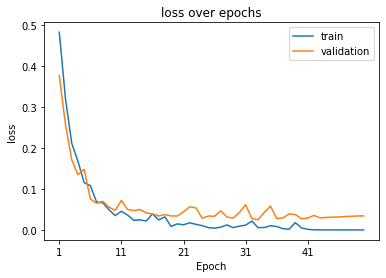

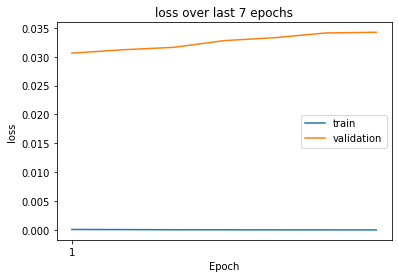

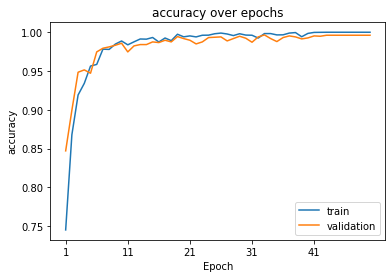

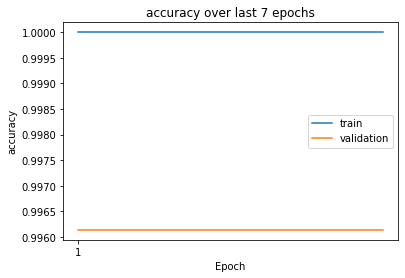

In [71]:
pretty_plot(history, 'loss')
pretty_plot(history, 'accuracy')